In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from matplotlib import pyplot as plt

import IPython.display as ipd
import librosa
from glob import glob
import time
from torch import nn
from torch.nn import functional as F
import torch
import torchvision
torch.cuda.is_available()

True

In [3]:
from birds_utils import get_fourier_weights, DataGeneratorV2, Dataset, get_pytorch_model, get_pytorch_model_all_conv, split_files_simple

In [4]:
# sr = 44100
# class_audiofiles = np.load(f'class_audiofiles_{sr}.npy', allow_pickle=True)
# train_files, val_files, train_labels, val_labels = split_files_simple(class_audiofiles, ratio = 0.2)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
sr = 44100
saved_time = 1594590165
train_files = np.load(f'train_files_{sr}_{saved_time}.npy')
train_labels = np.load(f'train_labels_{sr}_{saved_time}.npy')
val_files = np.load(f'val_files_{sr}_{saved_time}.npy')
val_labels = np.load(f'val_labels_{sr}_{saved_time}.npy')

sr = 22050
train_files = [f.replace('npy_22050', 'npy_44100') for f in train_files]
val_files = [f.replace('npy_22050', 'npy_44100') for f in val_files]

train_files = [f.replace('npy_44100', 'npy_22050') for f in train_files]
val_files = [f.replace('npy_44100', 'npy_22050') for f in val_files]


N = 2
min_std = 0.5
duration = 5

params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 1}
classes = np.unique(train_labels)
n_classes = len(classes)
training_set = Dataset(list(train_files)*N, classes, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True)
training_generator = torch.utils.data.DataLoader(training_set, **params)

In [7]:
for X, y in training_generator:
    break
X.shape, y.shape

(torch.Size([32, 1, 110250]), torch.Size([32, 10]))

In [8]:
# Load model
window_size = 1024
model = get_pytorch_model_all_conv(window_size, resnet='resnet18', pretrained=True, n_classes=n_classes, init_fourier=True, train_fourier=False).to(device)
# state_dict = torch.load('model_best_multilabel.pth', map_location=torch.device('cuda'))
# model.load_state_dict(state_dict)

Using cache found in /home/usuario/.cache/torch/hub/pytorch_vision_v0.6.0


In [9]:
%time
model.eval()
spec, y_res = model(X.to(device))
spec.shape, y_res.shape

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 3.1 µs


(torch.Size([32, 512, 427]), torch.Size([32, 10]))

1.0167154


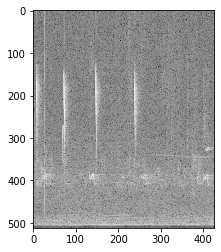

In [10]:
N = 5
sample_audio = X.detach().cpu().numpy()[N]
sample_spectrogram = spec.detach().cpu().numpy()[N, :,:]
plt.imshow(np.flipud(sample_spectrogram), cmap='gray')
print(sample_audio.std())
ipd.Audio(sample_audio.reshape(-1), rate=sr)

In [11]:
spec.max(), spec.min()

(tensor(1.0692, device='cuda:0', grad_fn=<MaxBackward1>),
 tensor(-0.1635, device='cuda:0', grad_fn=<MinBackward1>))

In [12]:
from birds_utils import validate, multilabel_metrics, get_F1_micro

In [13]:
# avg_loss, avg_F1, avg_acc = validate(validation_generator, metrics_func=multilabel_metrics)

In [19]:
def train_model(dataset, validation_generator, criterion, name, metrics_func=multilabel_metrics, epochs=1, best_metric = 0):
    model.train()
    batches_per_epoch = len(dataset)
    for epoch in range(epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        TPs = 0
        FPs = 0
        FNs = 0
        total_predictions = 0
        for i, (X, y) in enumerate(dataset):
            # Get the inputs; data is a list of [inputs, labels]
            inputs, labels = X.to(device), y.to(device)
            # (1) Initialise gradients
            optimizer.zero_grad()
            # (2) Forward pass
            _, y_pred = model(inputs)
            loss = criterion(y_pred, labels)
            running_loss = running_loss + loss
            # (3) Backward
            loss.backward()
            # (4) Compute the loss and update the weights
            optimizer.step()
            TP, FP, FN, micro_F1, total = metrics_func(y_pred, labels)
            TPs = TPs + TP.sum()
            FPs = FPs + FP.sum()
            FNs = FNs + FN.sum()
            total_predictions = total_predictions + total
            
            avg_loss = running_loss/(i+1)
            avg_F1 = get_F1_micro(TPs, FPs, FNs)
            avg_acc = TPs/total_predictions
            print(f'\r{epoch+1}/{epochs} - {i+1}/{batches_per_epoch} - loss: {avg_loss}, F1 micro: {avg_F1}, acc: {avg_acc}', end='')
        
        print()
        avg_loss, avg_F1, avg_acc = validate(model, validation_generator, criterion, device, metrics_func=multilabel_metrics)
        if avg_F1>best_metric:
            best_metric = avg_F1
            print()
            print('Best model saved')
            torch.save(model.state_dict(), f'{name}_{int(best_metric*1000 + 0.5)/1000}.pth')
        else:
            print()
        print('--------------------------------------------------------------------------')
        

In [15]:
params = {'batch_size': 16,
          'shuffle': True,
          'num_workers': 1}
classes = np.unique(train_labels)

N = 7
training_set = Dataset(list(train_files)*N, classes, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=True)
validation_set = Dataset(list(val_files)*N, classes, chunk_seconds=duration, sr=sr, min_std=min_std, multilabel=True, add_noise=False)
training_generator = torch.utils.data.DataLoader(training_set, **params)
validation_generator = torch.utils.data.DataLoader(validation_set, **params)

In [16]:
# avg_loss, avg_F1, avg_acc = validate(model, validation_generator, criterion, device, metrics_func=multilabel_metrics)

In [23]:
LEARNING_RATE = 0.0001
# criterion = torch.nn.CrossEntropyLoss()
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# state_dict = torch.load('model_6_0.8288726210594177.pth', map_location=torch.device('cuda'))
# model.load_state_dict(state_dict)

In [ ]:
train_model(training_generator, validation_generator, criterion, 'model_noise', epochs=10, metrics_func=multilabel_metrics, best_metric=0.8587570190429688)

1/10 - 115/340 - loss: 0.013422762043774128, F1 micro: 0.9755158424377441, acc: 0.9635869264602661

In [ ]:
# 14/20 - 340/340 - loss: 0.012936275452375412, F1 micro: 0.9772475361824036, acc: 0.9713182449340825
# 83/83 - val loss: 0.11272670328617096, val F1 micro: 0.8410007953643799 val acc: 0.7876039147377014
# Best model saved

In [21]:
torch.save(model.state_dict(), 'model_last_ml_std_auto_0.8750.pth')

In [22]:
# print(torch.cuda.memory_summary(device=None, abbreviated=False))

In [ ]:
X_img = torch.from_numpy(np.random.rand(2, 1, 44100)).float()